In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

*Non Negative Matrix Factorization*

Loading dataset...
done in 0.552s.
Extracting tf-idf features for NMF...
done in 0.143s.
Extracting tf features for LDA...
done in 0.143s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.045s.


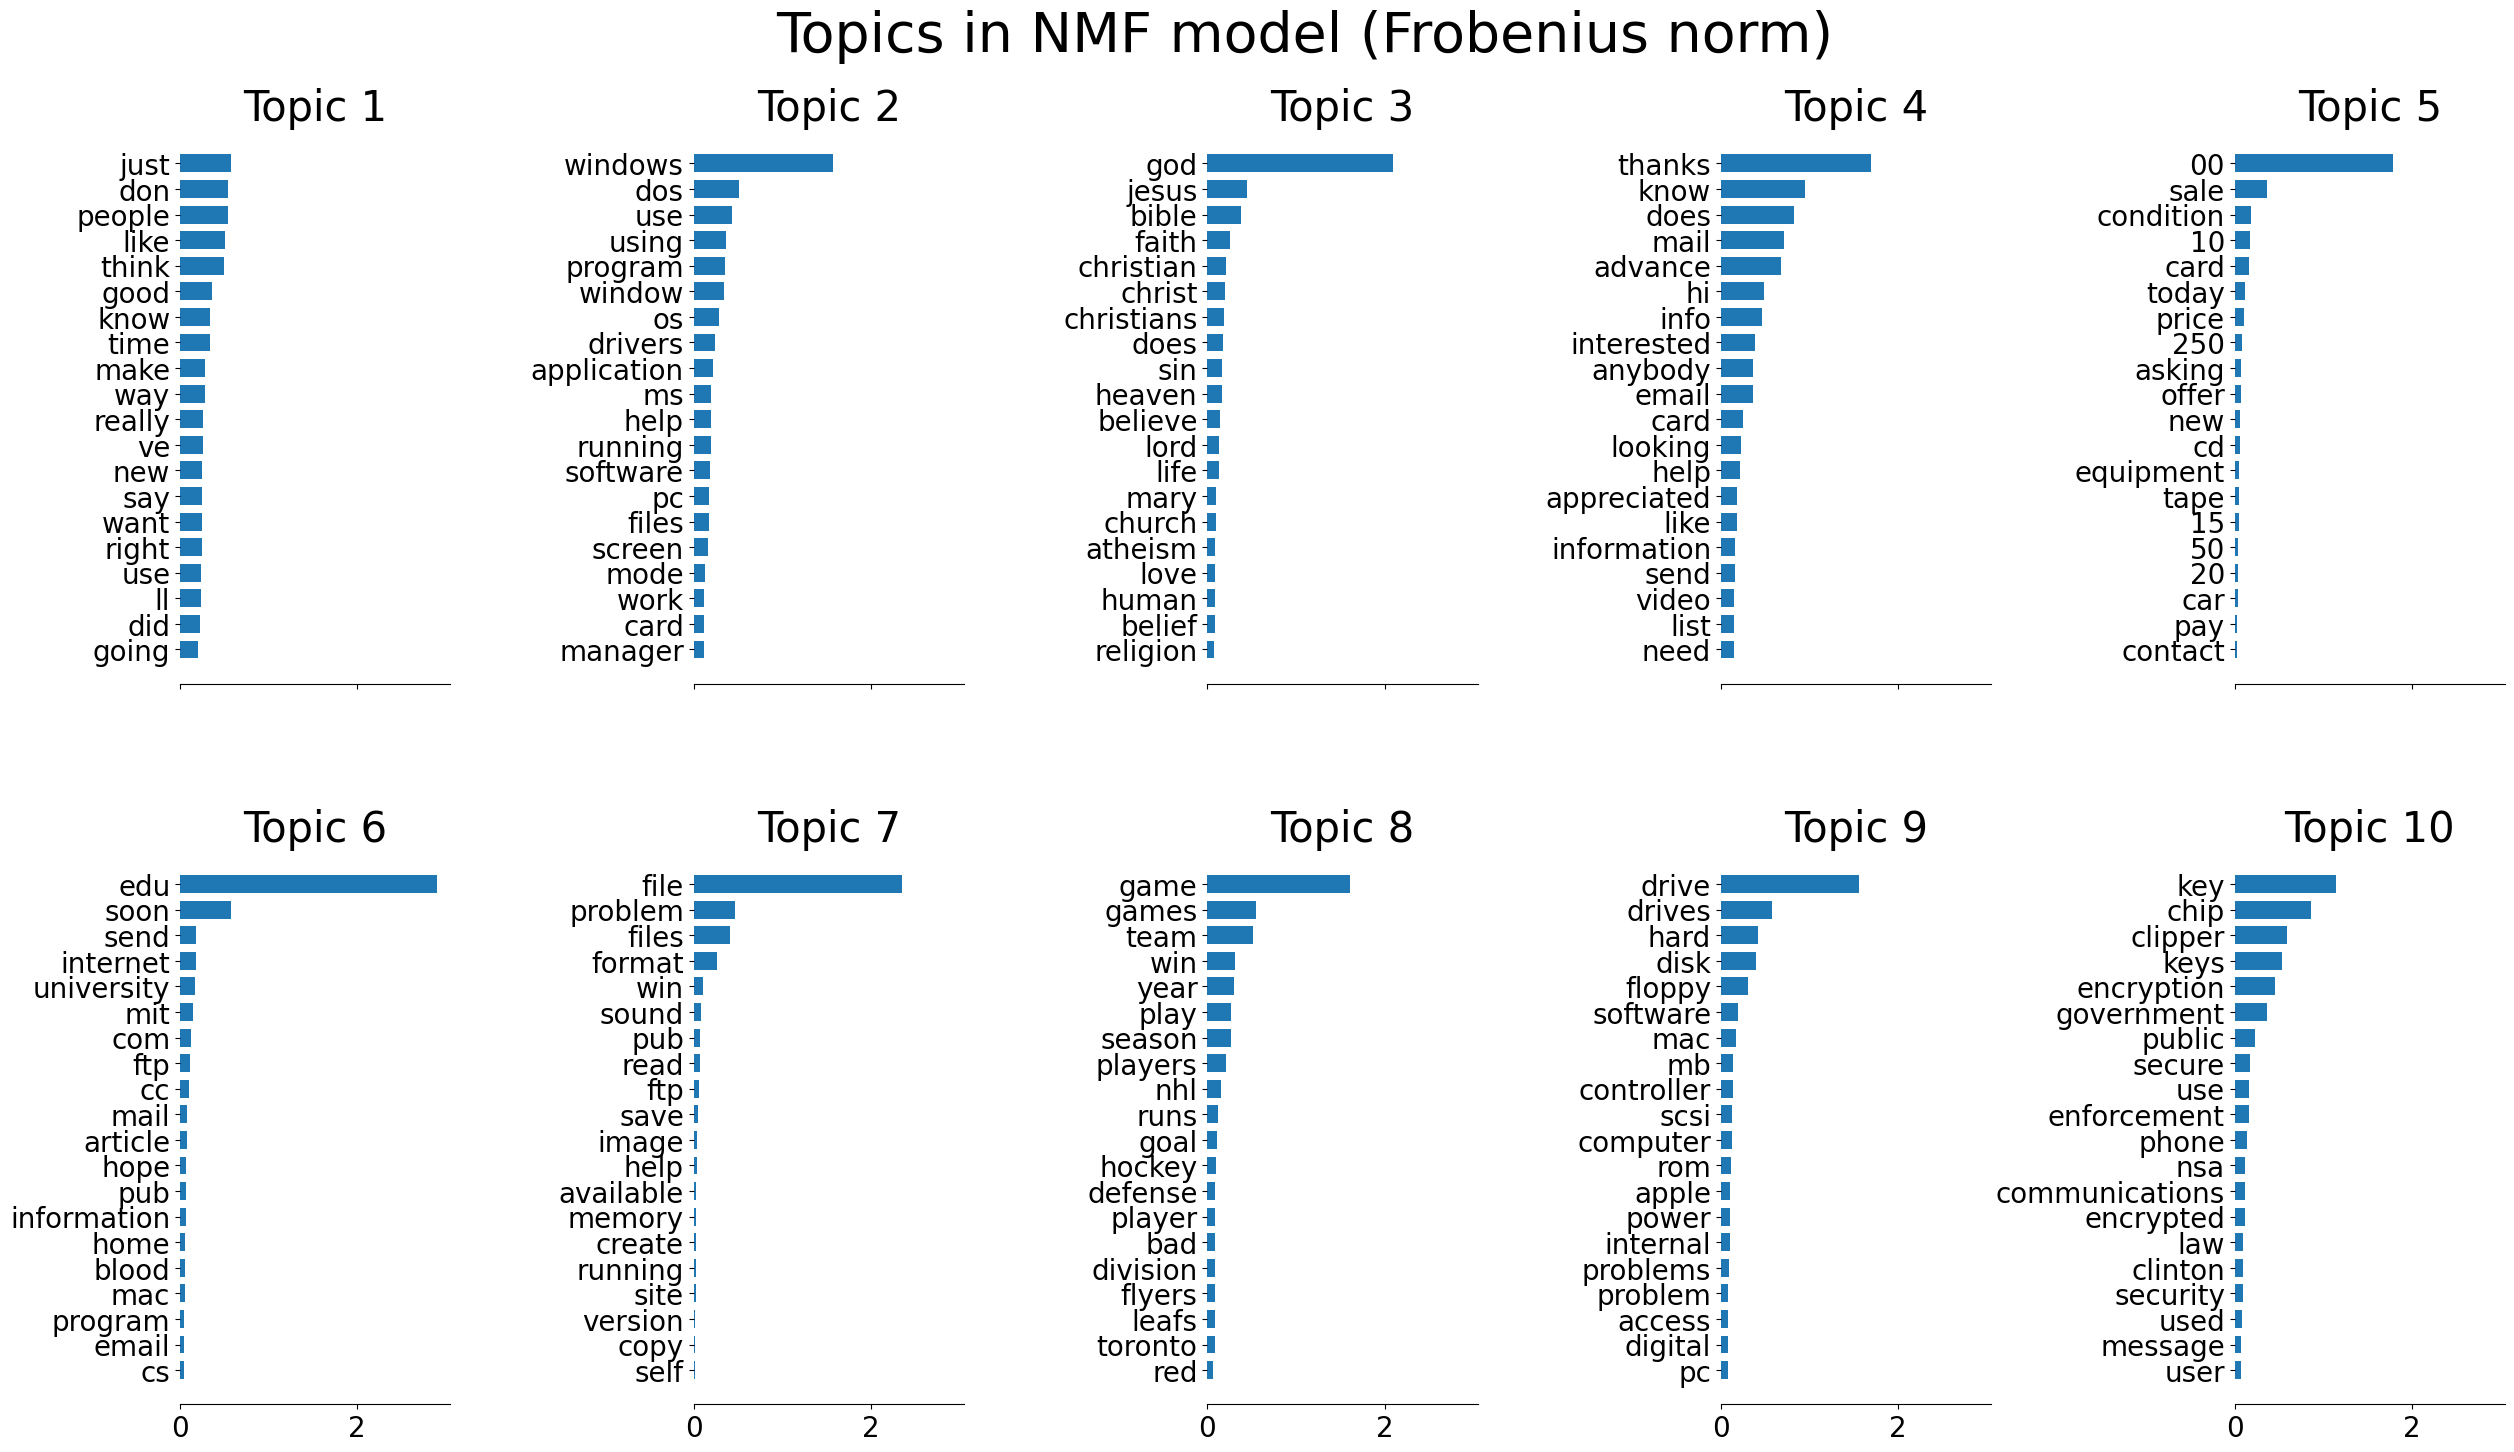



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.445s.


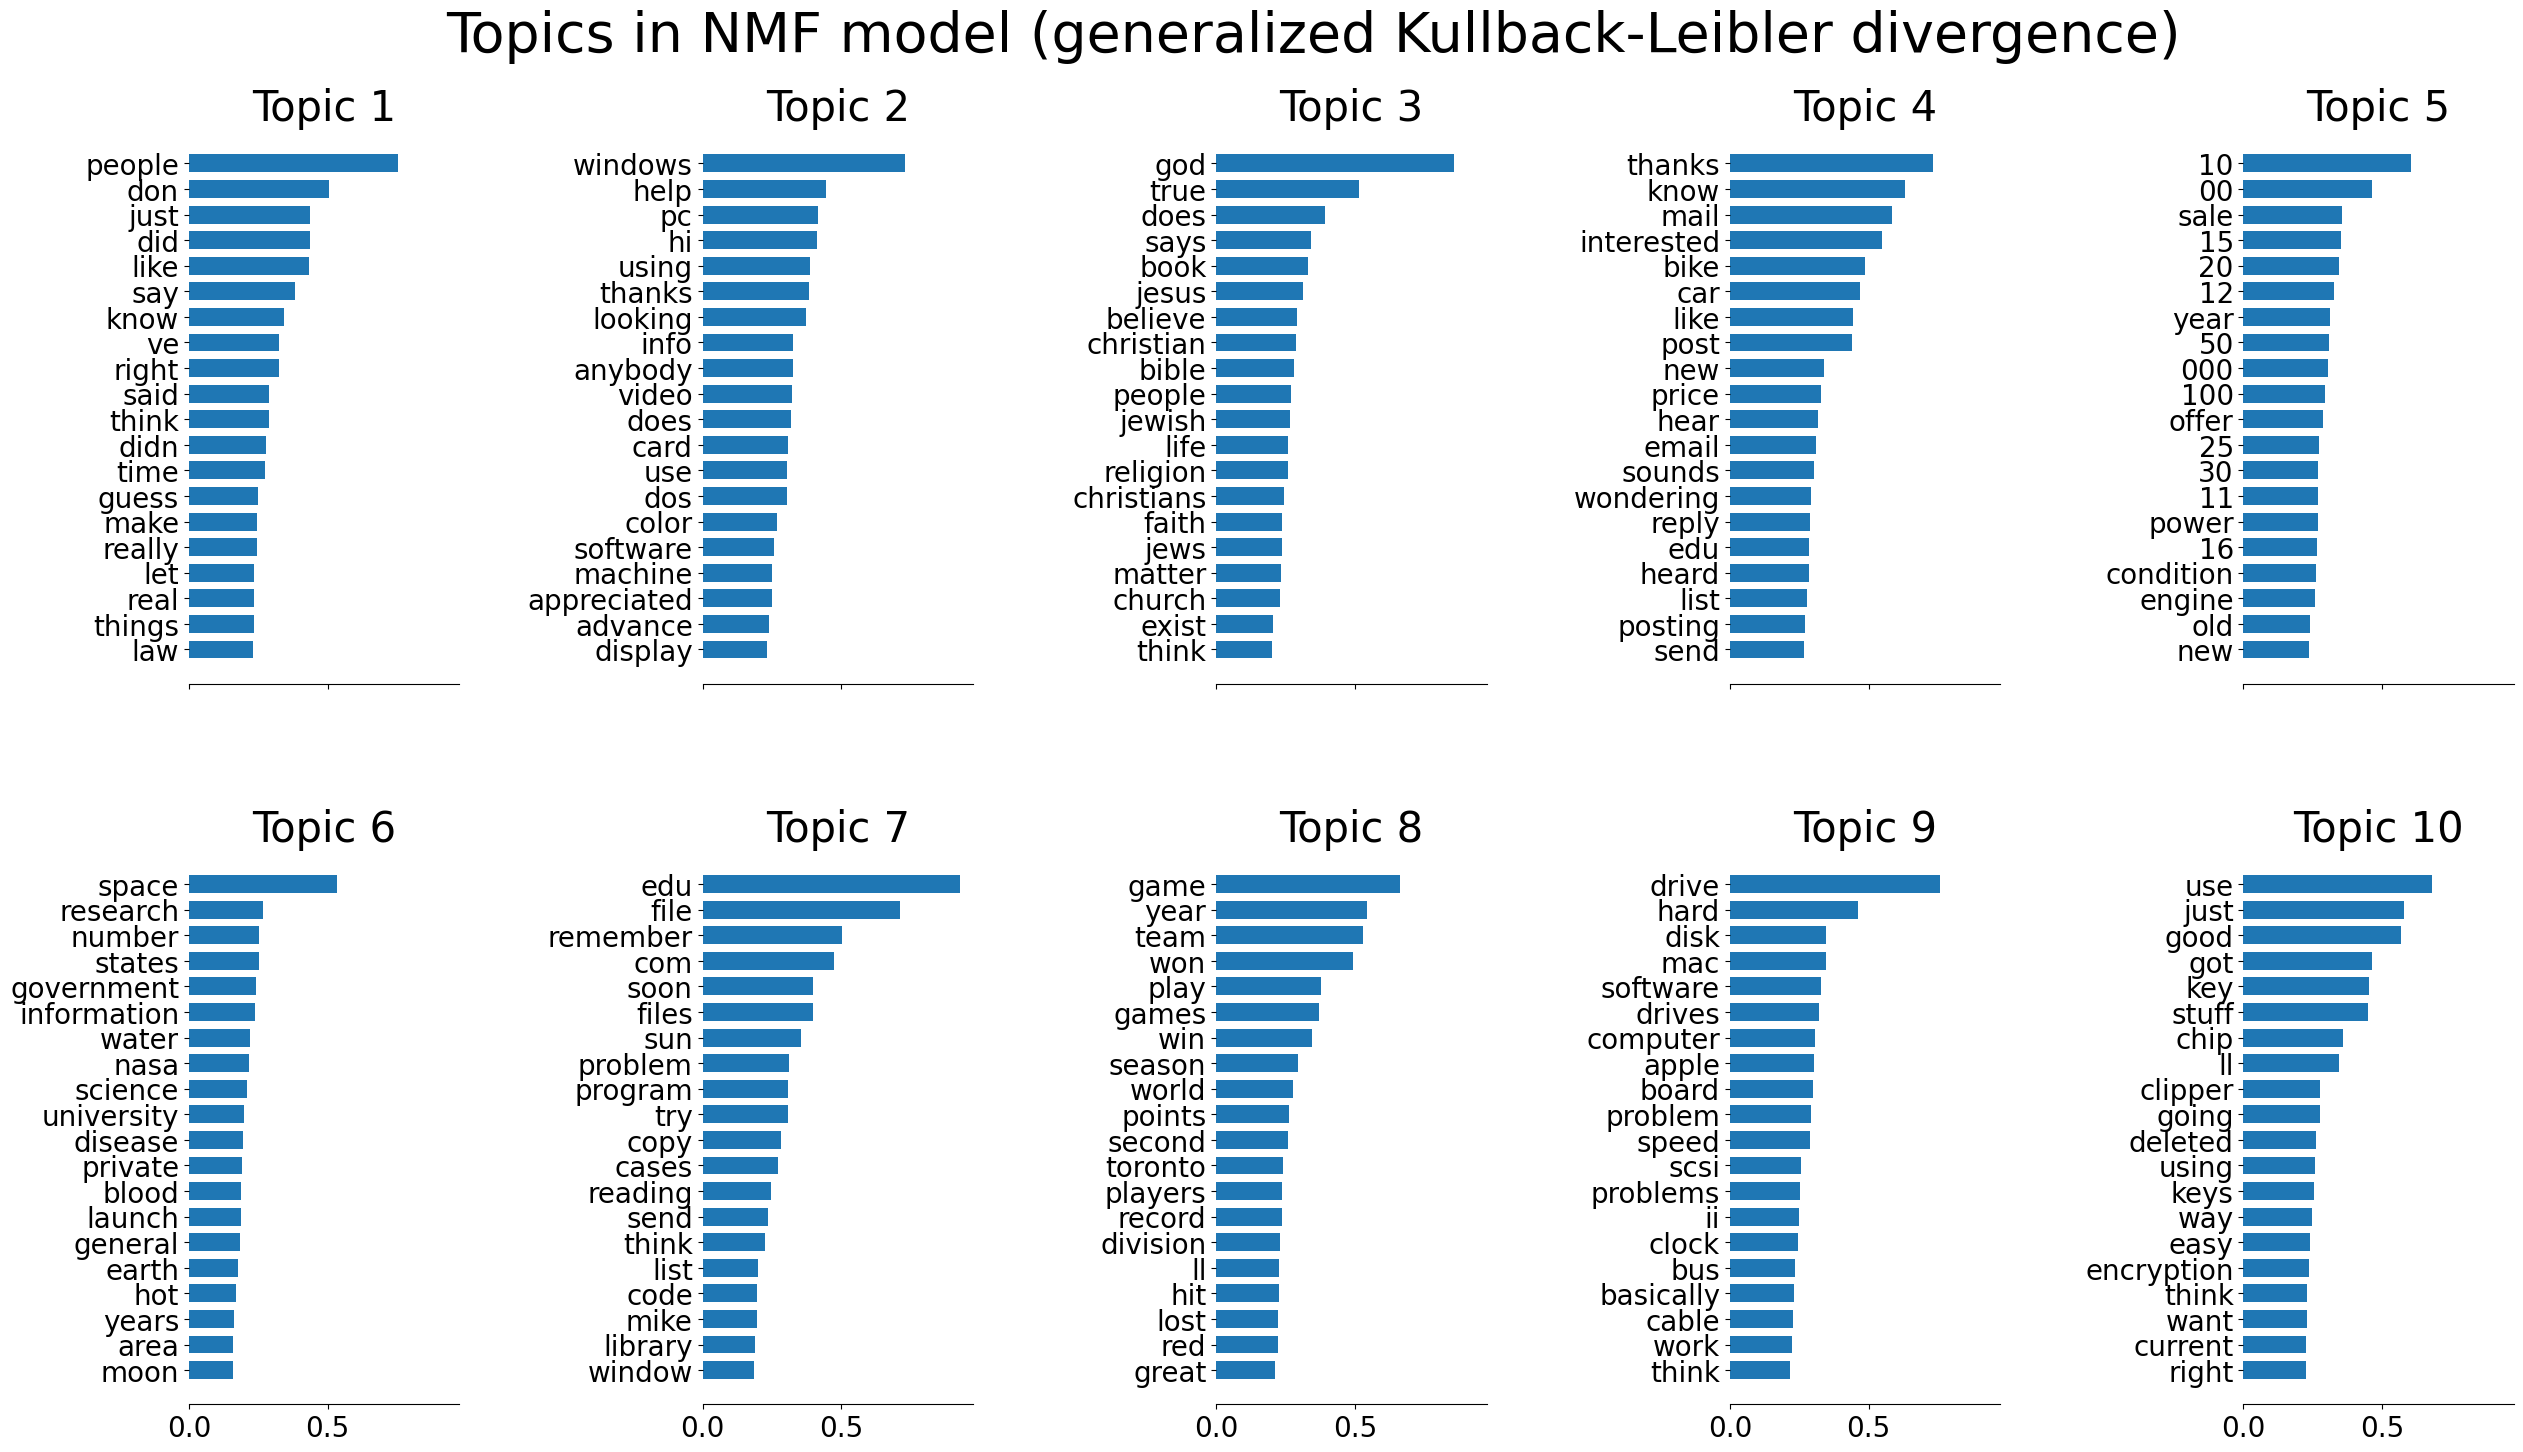



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...
done in 0.044s.


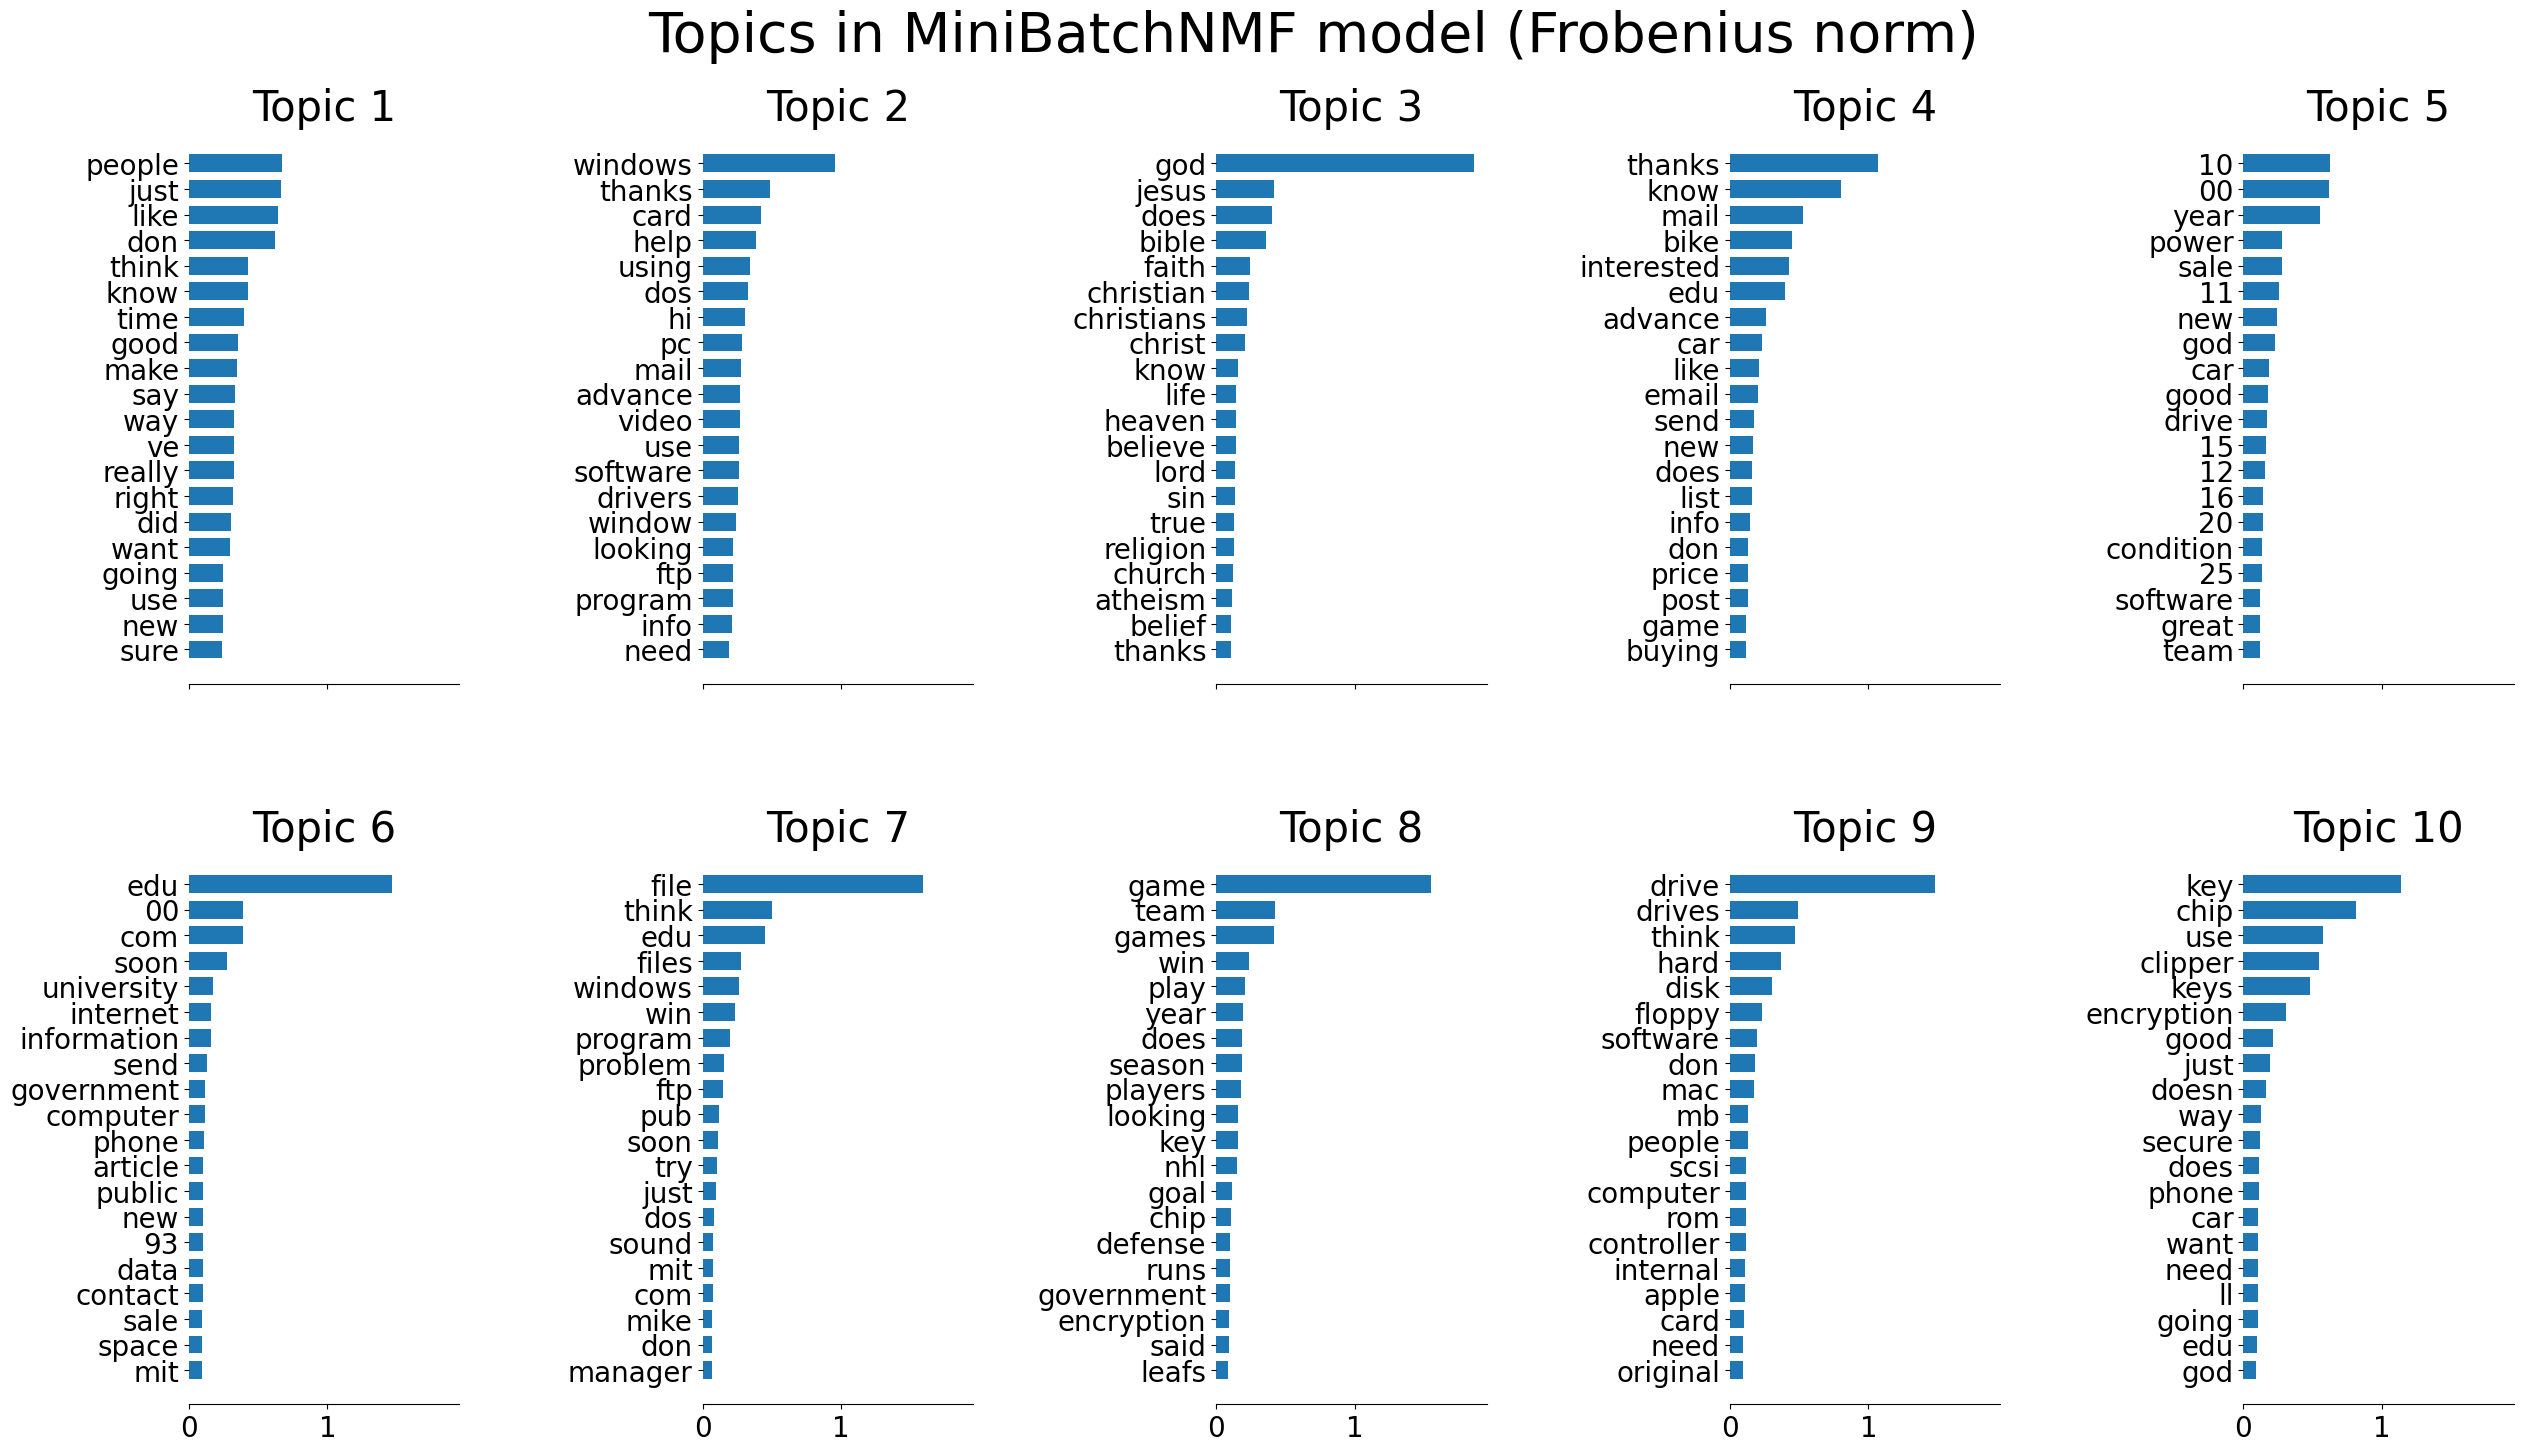



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...
done in 0.114s.


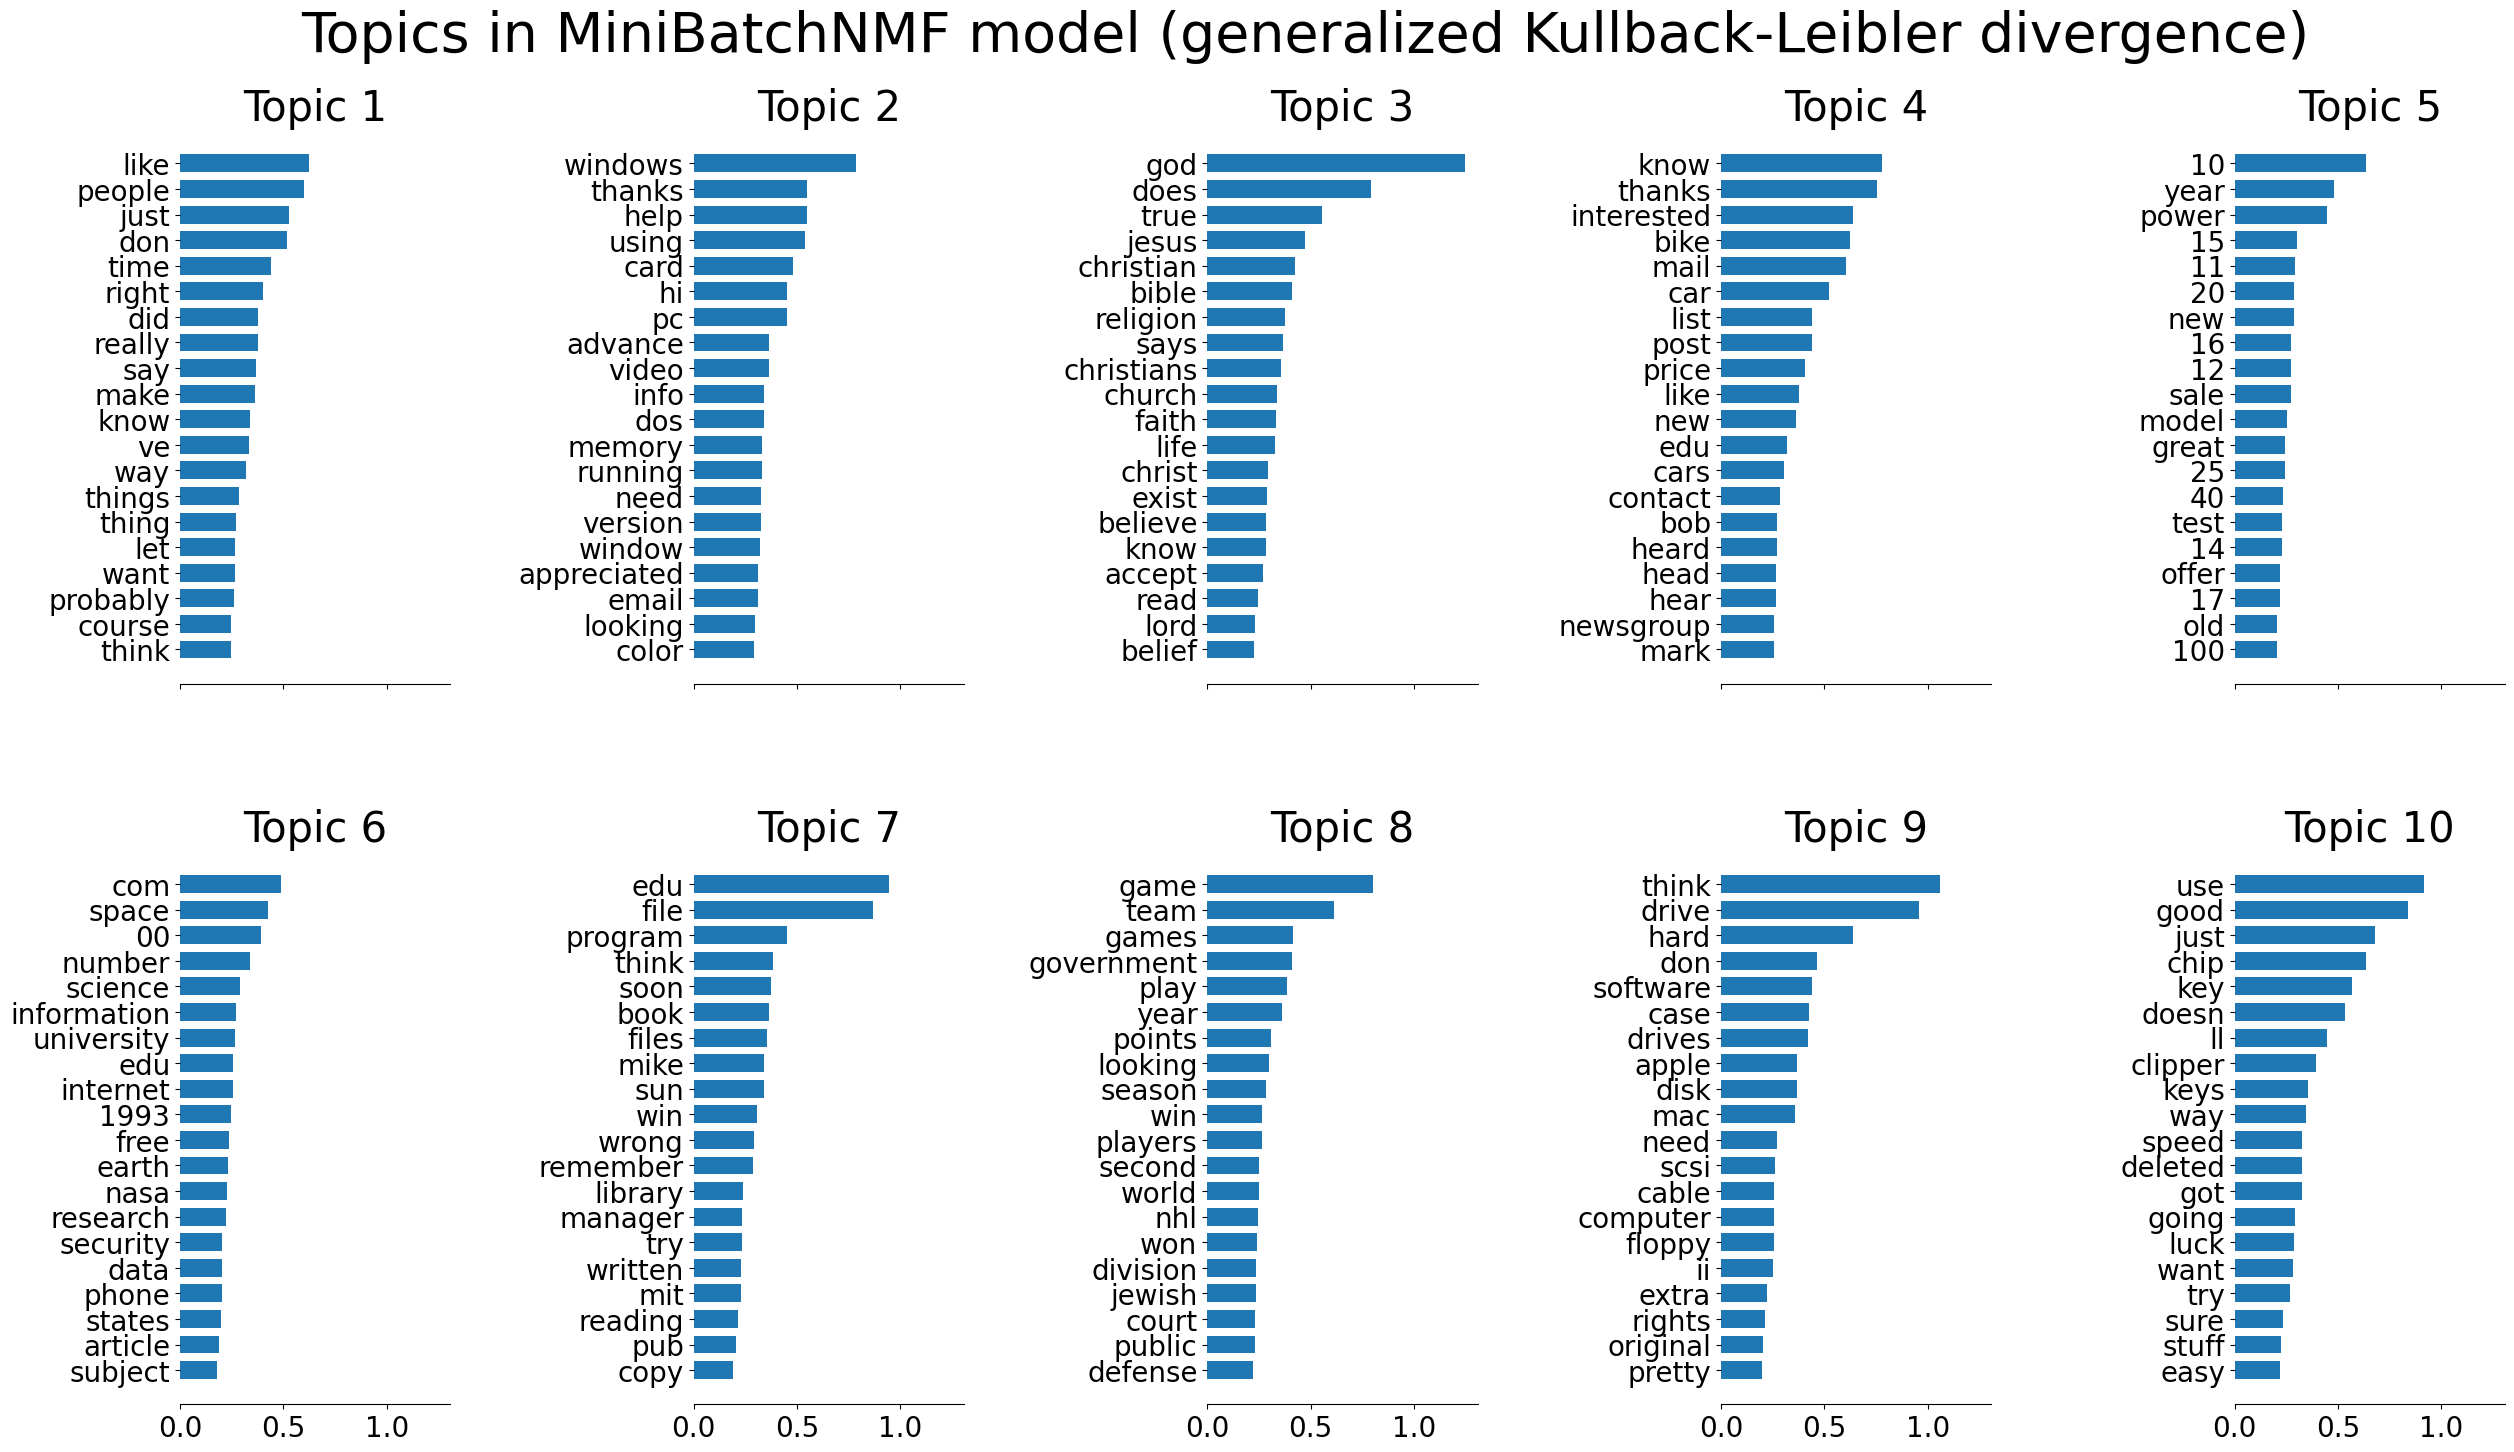



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 0.836s.


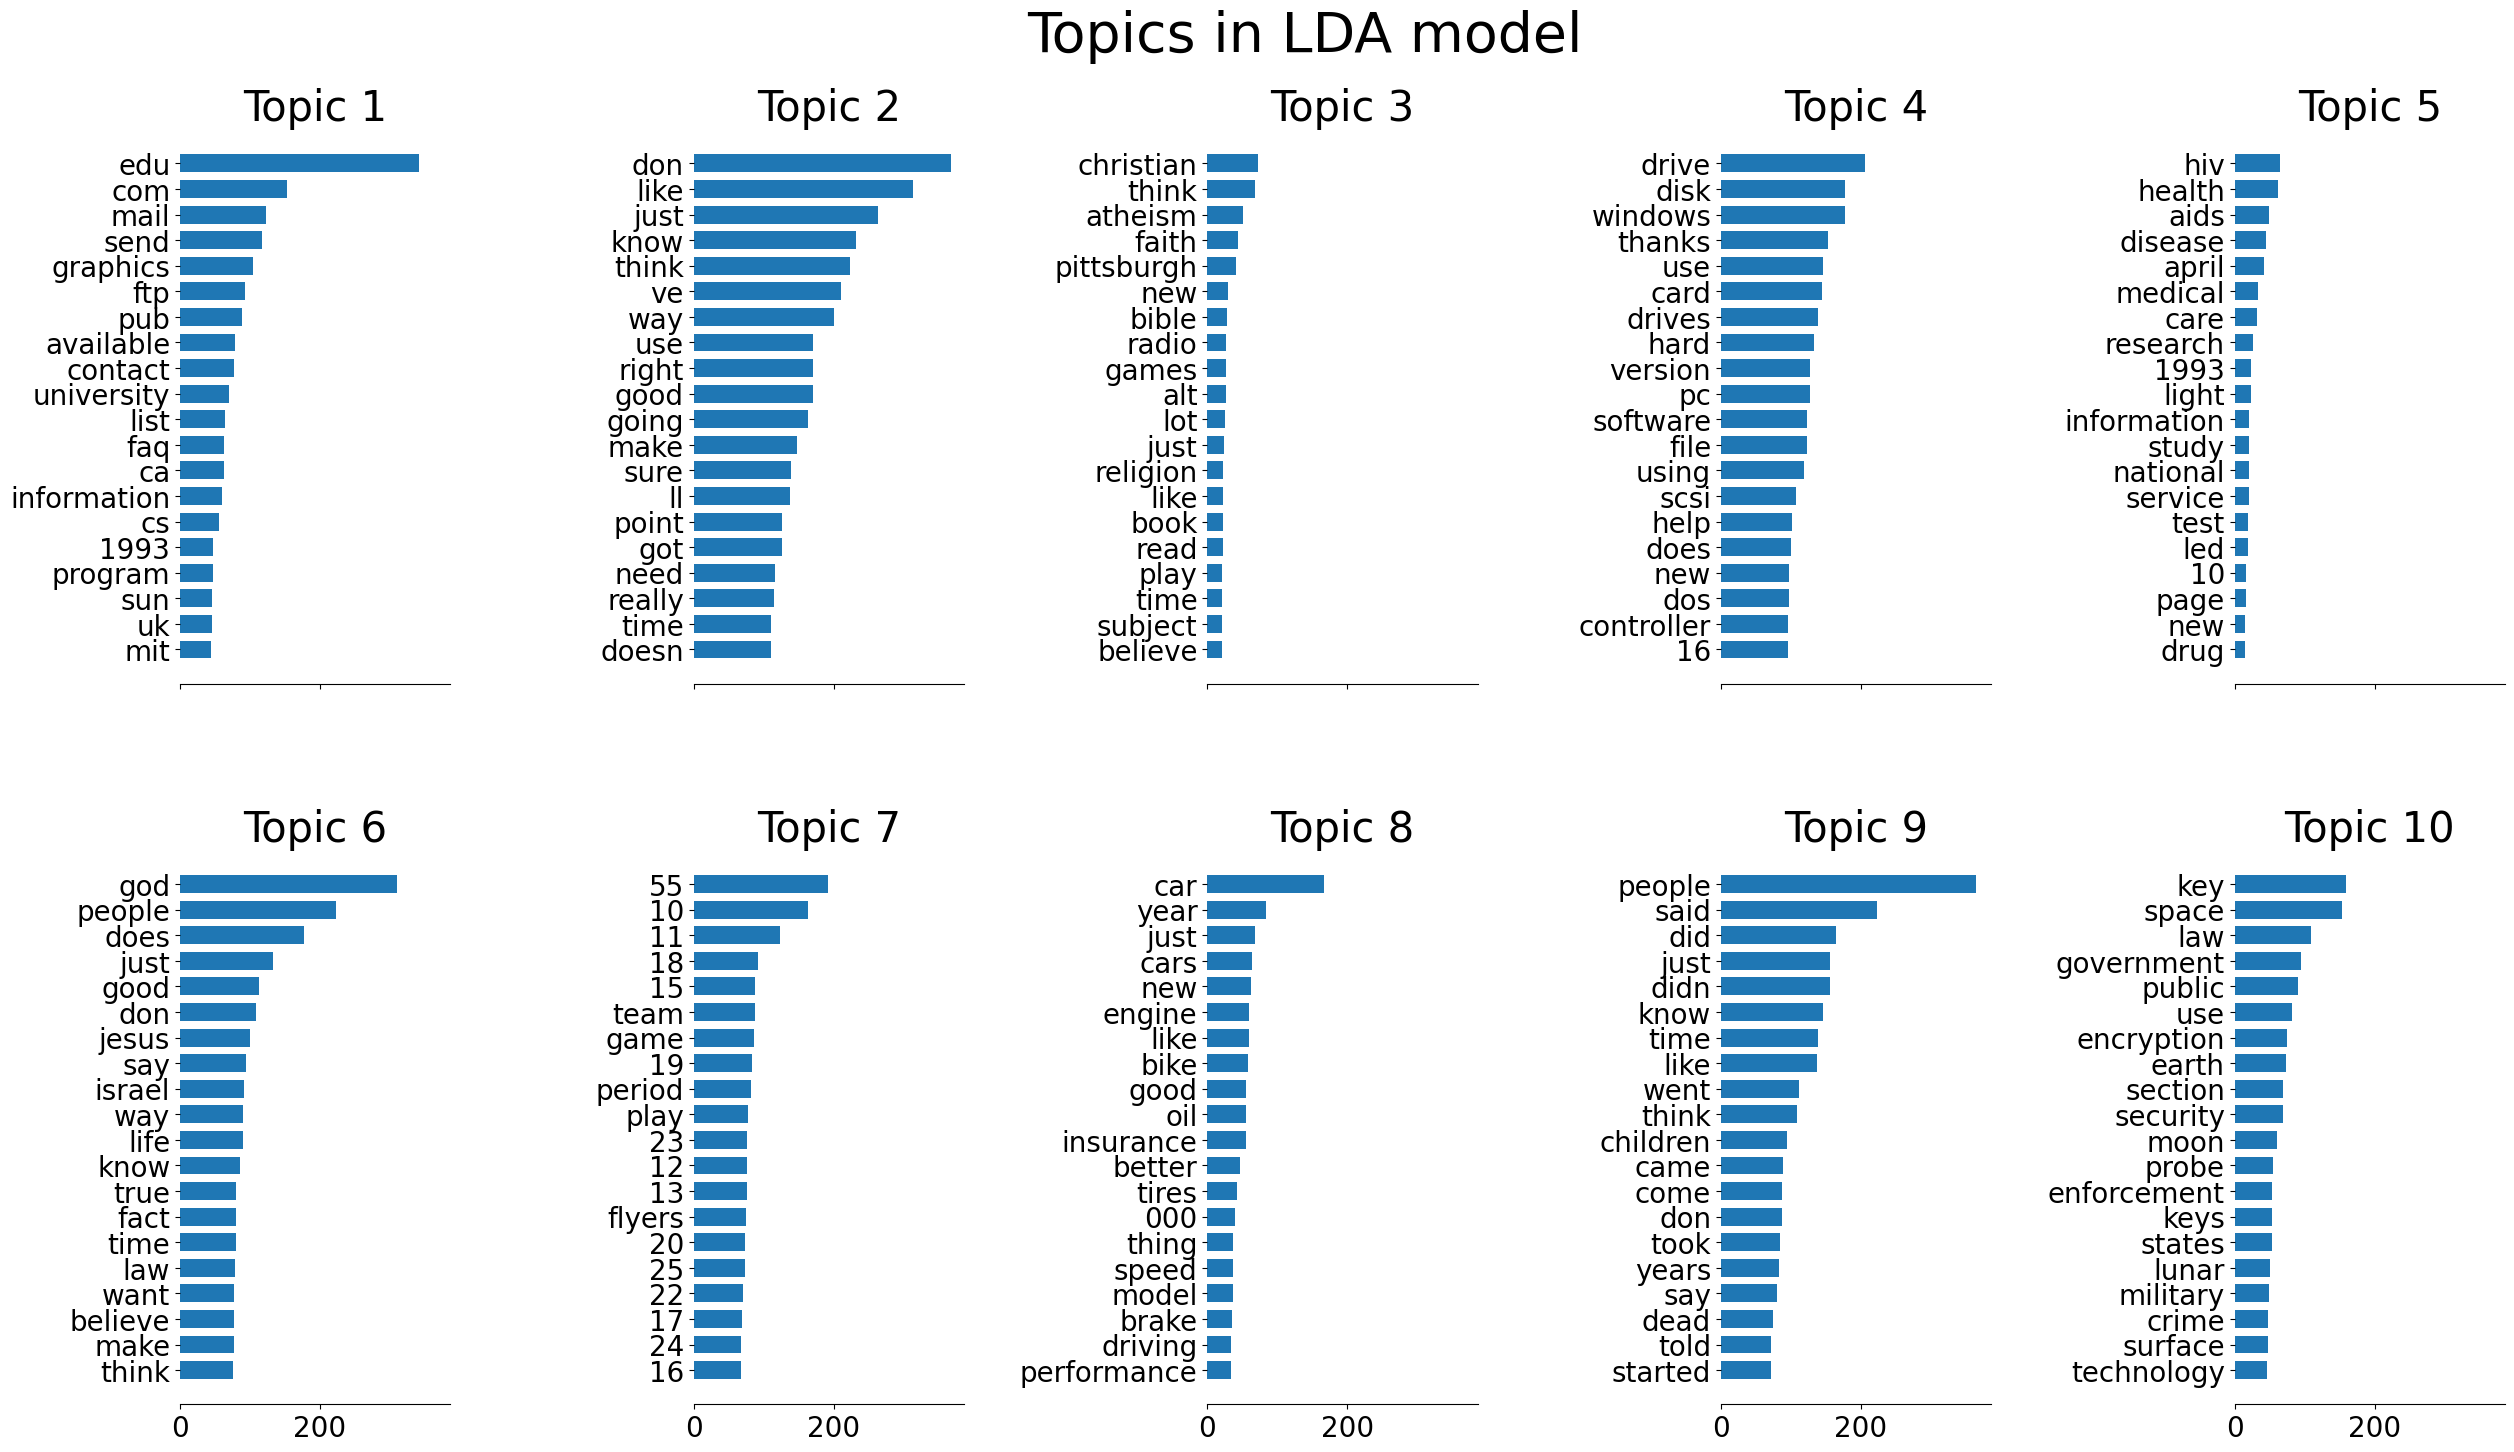

In [3]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [4]:
import numpy as np

def normalize_matrix(W):
    """Normalize each column of W to have L2 norm of 1."""
    norms = np.linalg.norm(W, axis=0)  # Compute column-wise norms
    W_normalized = W / norms  # Normalize each column by its norm
    return W_normalized, norms

def rescale_H(H, W_norms):
    """Rescale H to match normalized W."""
    for i in range(H.shape[0]):  # Iterate over rows of H
        H[i, :] *= W_norms[i]  # Rescale each row of H by the norm of corresponding W column
    return H

def initialize_NMF(A, rank):
    """Initialize NMF with NNDSVD, then normalize W and rescale H."""
    # Step 1: Initialize W and H (NNDSVD or another method)
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    W = U[:, :rank]  # Take the first 'rank' columns
    H = np.diag(S[:rank]) @ Vt[:rank, :]  # Construct H from S and Vt

    # Step 2: Normalize W column-wise
    W_normalized, W_norms = normalize_matrix(W)

    # Step 3: Rescale H
    H = rescale_H(H, W_norms)

    return W_normalized, H

# Example usage:
A = np.random.rand(10, 5)  # Example matrix to factorize
rank = 3
W_init, H_init = initialize_NMF(A, rank)


In [5]:
import numpy as np

def decay_singular_values(U, S, Vt, lambda_decay=0.1):
    """
    Apply exponential decay to singular values and adjust U, S, Vt accordingly.
    - U, S, Vt: SVD components of matrix A
    - lambda_decay: Decay parameter for singular values
    
    Returns decayed U, S, Vt
    """
    # Apply exponential decay to singular values
    S_decayed = S * np.exp(-lambda_decay * np.arange(len(S)))
    
    # Reconstruct the decayed approximation A'
    Sigma_decayed = np.diag(S_decayed)
    U_decayed = U[:, :len(S_decayed)]
    Vt_decayed = Vt[:len(S_decayed), :]
    
    return U_decayed, S_decayed, Vt_decayed

def initialize_NMF_with_decay(A, rank, lambda_decay=0.1):
    """
    Initialize NMF with decaying singular values.
    - A: The matrix to be factorized
    - rank: Rank of the factorization
    - lambda_decay: Decay parameter for singular values
    
    Returns normalized W and H for NMF.
    """
    # Step 1: Perform SVD on A
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    
    # Step 2: Apply exponential decay to singular values
    U_decayed, S_decayed, Vt_decayed = decay_singular_values(U, S, Vt, lambda_decay)
    
    # Step 3: Initialize W and H
    W = U_decayed[:, :rank] @ np.diag(np.sqrt(S_decayed[:rank]))
    H = np.diag(np.sqrt(S_decayed[:rank])) @ Vt_decayed[:rank, :]
    
    return W, H

# Example usage:
A = np.random.rand(10, 5)  # Example matrix to factorize
rank = 3
lambda_decay = 0.1  # Decay rate for singular values
W_init, H_init = initialize_NMF_with_decay(A, rank, lambda_decay)



In [6]:
from sklearn.utils import check_random_state
import numpy as np

def randomized_svd(A, rank, n_iter=5, random_state=None):
    random_state = check_random_state(random_state)
    n, m = A.shape
    # Step 1: Randomly project A onto a lower-dimensional space
    random_matrix = random_state.normal(size=(m, rank))
    Y = np.dot(A, random_matrix)
    
    # Step 2: Apply QR decomposition to ensure orthogonality
    Q, _ = np.linalg.qr(Y)
    
    # Step 3: Compute a reduced SVD
    B = np.dot(Q.T, A)
    U, S, Vt = np.linalg.svd(B, full_matrices=False)
    
    # Step 4: Compute low-rank approximation
    U = np.dot(Q, U)
    
    return U[:, :rank], S[:rank], Vt[:rank, :]

# Example usage
A = np.random.rand(100, 50)  # Example matrix to factorize
rank = 10
U, S, Vt = randomized_svd(A, rank)


In [7]:
import numpy as np
from scipy.linalg import hadamard
from sklearn.decomposition import NMF

def next_power_of_2(x):
    """Returns the next power of 2 greater than or equal to x."""
    return 1 if x == 0 else 2**(x - 1).bit_length()

def fjlt_transform(A, d):
    """
    Applies Fast Johnson-Lindenstrauss Transform (FJLT) to reduce dimensions.
    Uses a Hadamard-based random projection for efficiency.
    
    Parameters:
        A (numpy.ndarray): Input matrix of shape (m, n)
        d (int): Target lower dimension
    
    Returns:
        numpy.ndarray: Transformed matrix
    """
    m, n = A.shape
    d = min(n, d)  # Ensure d does not exceed n
    hadamard_size = next_power_of_2(n)  # Ensure H operates on n
    H = hadamard(hadamard_size)[:n, :n]  # Square Hadamard matrix
    R = np.random.choice([-1, 1], size=(n, d)) / np.sqrt(d)  # Random sign matrix
    A_fjlt = (A @ H) @ R  # Apply H to A properly, no slicing required
    
    if A_fjlt is None or A_fjlt.size == 0:
        raise ValueError("FJLT transformation returned an invalid matrix")
    
    return A_fjlt

def nmf_fjlt_init(A, rank):
    """
    Initializes NMF using FJLT-based randomized SVD.
    
    Parameters:
        A (numpy.ndarray): Input non-negative matrix (m, n)
        rank (int): Target rank for NMF
    
    Returns:
        W_init, H_init: Initialized factor matrices
    """
    # Step 1: Apply FJLT to A
    A_fjlt = fjlt_transform(A, rank)
    print("A_fjlt shape:", A_fjlt.shape)
    
    # Step 2: Apply SVD on transformed matrix
    U, S, Vt = np.linalg.svd(A_fjlt, full_matrices=False)
    min_dim = min(U.shape[1], Vt.shape[0], rank)  # Ensure valid rank selection
    
    # Step 3: Construct non-negative initial factors
    W_init = np.abs(U[:, :min_dim] @ np.diag(np.sqrt(S[:min_dim])))  # W_init shape: (m, rank)
    H_init = np.abs(np.diag(np.sqrt(S[:min_dim])) @ Vt[:min_dim, :])  # H_init shape: (rank, d)
    
    # Step 4: Project H_init back to the original space
    # Since A_fjlt has shape (m, d), we need to map H_init back to (rank, n)
    # Use the random projection matrix R from fjlt_transform to reverse the transformation
    hadamard_size = next_power_of_2(A.shape[1])  # Ensure H operates on n
    H = hadamard(hadamard_size)[:A.shape[1], :A.shape[1]]  # Square Hadamard matrix
    R = np.random.choice([-1, 1], size=(A.shape[1], rank)) / np.sqrt(rank)  # Random sign matrix
    H_init = H_init @ R.T  # Project H_init back to (rank, n)
    H_init = np.maximum(H_init, 0)
    print("W_init shape:", W_init.shape)
    print("H_init shape:", H_init.shape)
    
    return W_init, H_init

def nmf_with_fjlt(A, rank, max_iter=200):
    """
    Runs NMF with FJLT-based initialization.
    
    Parameters:
        A (numpy.ndarray): Input non-negative matrix (m, n)
        rank (int): Target rank for NMF
        max_iter (int): Maximum number of NMF iterations
    
    Returns:
        W, H: Factorized matrices from NMF
    """
    W_init, H_init = nmf_fjlt_init(A, rank)
    
    # Ensure W_init is of shape (m, rank) and H_init is of shape (rank, n)
    if W_init.shape[1] != rank or H_init.shape[0] != rank:
        raise ValueError(f"Invalid shapes for W_init or H_init: W_init shape: {W_init.shape}, H_init shape: {H_init.shape}")
    
    print(f"A shape: {A.shape}, W_init shape: {W_init.shape}, H_init shape: {H_init.shape}")
    
    # Initialize NMF with custom W_init and H_init
    nmf = NMF(n_components=rank, init='custom', max_iter=max_iter, solver='mu')
    nmf.fit(A, W=W_init, H=H_init)  # Use fit instead of fit_transform
    W = nmf.transform(A)  # Use transform to get W from the fitted model
    H = nmf.components_  # The H matrix is stored as components_
    
    return W, H

# Example Usage:
m, n, rank = 100, 50, 5
A = np.abs(np.random.randn(m, n))  # Simulated non-negative matrix
W, H = nmf_with_fjlt(A, rank,max_iter=2000)
print("W shape:", W.shape)
print("H shape:", H.shape)

A_reconstructed = W @ H

# Calculate reconstruction error
reconstruction_error = np.linalg.norm(A - A_reconstructed, ord='fro')

# Calculate Frobenius norm of A
norm_A = np.linalg.norm(A, ord='fro')

# Calculate relative error
relative_error = reconstruction_error / norm_A

print(relative_error)

A_fjlt shape: (100, 5)
W_init shape: (100, 5)
H_init shape: (5, 50)
A shape: (100, 50), W_init shape: (100, 5), H_init shape: (5, 50)
W shape: (100, 5)
H shape: (5, 50)
0.7121979501258885


In [22]:
import numpy as np
from scipy.linalg import hadamard
from sklearn.decomposition import NMF

def next_power_of_2(x):
    """Returns the next power of 2 greater than or equal to x."""
    return 1 if x == 0 else 2**(x - 1).bit_length()

def pad_to_power_of_2(A):
    """
    Pads the input matrix A with zeros to the next power of 2.
    
    Parameters:
        A (numpy.ndarray): Input matrix of shape (m, n)
    
    Returns:
        numpy.ndarray: Padded matrix
    """
    m, n = A.shape
    padded_n = next_power_of_2(n)
    if padded_n == n:
        return A  # No padding needed
    else:
        # Pad with zeros to the next power of 2
        return np.pad(A, ((0, 0), (0, padded_n - n)), mode='constant')

def fjlt_transform(A, d):
    """
    Applies Fast Johnson-Lindenstrauss Transform (FJLT) to reduce dimensions.
    Uses a Hadamard-based random projection for efficiency.
    
    Parameters:
        A (numpy.ndarray): Input matrix of shape (m, n)
        d (int): Target lower dimension
    
    Returns:
        numpy.ndarray: Transformed matrix
    """
    m, n = A.shape
    d = min(n, d)  # Ensure d does not exceed n
    
    # Pad A to the next power of 2
    A_padded = pad_to_power_of_2(A)
    padded_n = A_padded.shape[1]
    
    # Construct Hadamard matrix of size padded_n
    H = hadamard(padded_n)
    
    # Random sign matrix
    R = np.random.choice([-1, 1], size=(padded_n, d)) / np.sqrt(d)
    
    # Apply FJLT: A_padded @ H @ R
    A_fjlt = (A_padded @ H) @ R
    
    # Truncate back to the original dimensionality (if padding was applied)
    if padded_n != n:
        A_fjlt = A_fjlt[:, :d]
    
    if A_fjlt is None or A_fjlt.size == 0:
        raise ValueError("FJLT transformation returned an invalid matrix")
    
    return A_fjlt

def nmf_fjlt_init(A, rank):
    """
    Initializes NMF using FJLT-based randomized SVD.
    
    Parameters:
        A (numpy.ndarray): Input non-negative matrix (m, n)
        rank (int): Target rank for NMF
    
    Returns:
        W_init, H_init: Initialized factor matrices
    """
    # Step 1: Apply FJLT to A
    A_fjlt = fjlt_transform(A, rank)
    print("A_fjlt shape:", A_fjlt.shape)
    
    # Step 2: Apply SVD on transformed matrix
    U, S, Vt = np.linalg.svd(A_fjlt, full_matrices=False)
    min_dim = min(U.shape[1], Vt.shape[0], rank)  # Ensure valid rank selection
    
    # Step 3: Construct non-negative initial factors
    W_init = np.abs(U[:, :min_dim] @ np.diag(np.sqrt(S[:min_dim])))  # W_init shape: (m, rank)
    H_init = np.abs(np.diag(np.sqrt(S[:min_dim])) @ Vt[:min_dim, :])  # H_init shape: (rank, d)
    
    # Step 4: Project H_init back to the original space
    # Since A_fjlt has shape (m, d), we need to map H_init back to (rank, n)
    # Use the random projection matrix R from fjlt_transform to reverse the transformation
    hadamard_size = next_power_of_2(A.shape[1])  # Ensure H operates on n
    H = hadamard(hadamard_size)[:A.shape[1], :A.shape[1]]  # Square Hadamard matrix
    R = np.random.choice([-1, 1], size=(A.shape[1], rank)) / np.sqrt(rank)  # Random sign matrix
    H_init = H_init @ R.T  # Project H_init back to (rank, n)
    H_init = np.maximum(H_init, 0)
    print("W_init shape:", W_init.shape)
    print("H_init shape:", H_init.shape)
    
    return W_init, H_init

def nmf_with_fjlt(A, rank, max_iter=200):
    """
    Runs NMF with FJLT-based initialization.
    
    Parameters:
        A (numpy.ndarray): Input non-negative matrix (m, n)
        rank (int): Target rank for NMF
        max_iter (int): Maximum number of NMF iterations
    
    Returns:
        W, H: Factorized matrices from NMF
    """
    W_init, H_init = nmf_fjlt_init(A, rank)
    
    # Ensure W_init is of shape (m, rank) and H_init is of shape (rank, n)
    if W_init.shape[1] != rank or H_init.shape[0] != rank:
        raise ValueError(f"Invalid shapes for W_init or H_init: W_init shape: {W_init.shape}, H_init shape: {H_init.shape}")
    
    print(f"A shape: {A.shape}, W_init shape: {W_init.shape}, H_init shape: {H_init.shape}")
    
    # Initialize NMF with custom W_init and H_init
    nmf = NMF(n_components=rank, init='custom', max_iter=max_iter, solver='mu')
    nmf.fit(A, W=W_init, H=H_init)  # Use fit instead of fit_transform
    W = nmf.transform(A)  # Use transform to get W from the fitted model
    H = nmf.components_  # The H matrix is stored as components_
    
    return W, H

# Example Usage:
m, n, rank = 100, 50, 5
A = np.abs(np.random.randn(m, n))  # Simulated non-negative matrix
W, H = nmf_with_fjlt(A, rank, max_iter=2000)
print("W shape:", W.shape)
print("H shape:", H.shape)

A_reconstructed = W @ H

# Calculate reconstruction error
reconstruction_error = np.linalg.norm(A - A_reconstructed, ord='fro')

# Calculate Frobenius norm of A
norm_A = np.linalg.norm(A, ord='fro')

# Calculate relative error
relative_error = reconstruction_error / norm_A

A_fjlt shape: (100, 5)
W_init shape: (100, 5)
H_init shape: (5, 50)
A shape: (100, 50), W_init shape: (100, 5), H_init shape: (5, 50)
W shape: (100, 5)
H shape: (5, 50)


In [23]:
print(relative_error)

0.6017488425129915


In [28]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from scipy.linalg import hadamard

# Step 1: Load the dataset
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)
documents = newsgroups.data

# Step 2: Convert text data into a non-negative matrix using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Limit to 1000 features for simplicity
A = vectorizer.fit_transform(documents).toarray()  # Shape: (n_documents, n_features)
print("Original matrix shape:", A.shape)

# Step 3: Apply NMF with FJLT initialization
rank = 10  # Target rank for NMF
W, H = nmf_with_fjlt(A, rank,max_iter=2000)

# Step 4: Interpret the results
print("W shape:", W.shape)  # Document-topic matrix
print("H shape:", H.shape)  # Topic-term matrix

# Display the top terms for each topic
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

for topic_idx, topic in enumerate(H):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Original matrix shape: (2257, 1000)
A_fjlt shape: (2257, 10)
W_init shape: (2257, 10)
H_init shape: (10, 1000)
A shape: (2257, 1000), W_init shape: (2257, 10), H_init shape: (10, 1000)
W shape: (2257, 10)
H shape: (10, 1000)
Topic 0:
the of to with god there he as this are
Topic 1:
msg food to sensitivity dyer of steve berkeley foods me
Topic 2:
and of from is are my for use their your
Topic 3:
to if graphics any me for thanks ca help like
Topic 4:
edu keith sgi cs nntp writes com article solntze wpd
Topic 5:
is on of not that these what or by as
Topic 6:
the it com by church most at here about mail
Topic 7:
pitt banks gordon it is the and pittsburgh intellect skepticism
Topic 8:
that was his my jesus an people lines do have
Topic 9:
to your com he god are be have re about


In [29]:
reconstruction_error = np.linalg.norm(A - W @ H, ord='fro')
print("Reconstruction Error:", reconstruction_error)

Reconstruction Error: 41.60022218041022


In [31]:
nmf = NMF(n_components=rank,max_iter=2000,init = 'nndsvd')
nmf.fit(A)
W = nmf.transform(A)  # Use transform to get W from the fitted model
H = nmf.components_  # The H matrix is stored as components_
reconstruction_error = np.linalg.norm(A - W @ H, ord='fro')
print("Reconstruction Error:", reconstruction_error)

Reconstruction Error: 40.07346437484998


In [10]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.linalg import hadamard

# FJLT-based initialization
def fjlt_transform(A, d):
    m, n = A.shape
    d = min(n, d)
    hadamard_size = next_power_of_2(n)
    H = hadamard(hadamard_size)[:n, :n]
    R = np.random.choice([-1, 1], size=(n, d)) / np.sqrt(d)
    A_fjlt = (A @ H) @ R
    return A_fjlt

def nmf_fjlt_init(A, rank):
    A_fjlt = fjlt_transform(A, rank)
    U, S, Vt = np.linalg.svd(A_fjlt, full_matrices=False)
    min_dim = min(U.shape[1], Vt.shape[0], rank)
    W_init = np.abs(U[:, :min_dim] @ np.diag(np.sqrt(S[:min_dim])))
    H_init = np.abs(np.diag(np.sqrt(S[:min_dim])) @ Vt[:min_dim, :])
    return W_init, H_init

# Function to compute relative error
def compute_relative_error(A, W, H):
    reconstruction_error = np.linalg.norm(A - W @ H, ord='fro')
    norm_A = np.linalg.norm(A, ord='fro')
    return reconstruction_error / norm_A

# Example data
m, n, rank = 100, 50, 5
A = np.abs(np.random.randn(m, n))  # Simulated non-negative matrix

# Run NMF with FJLT initialization
print("Running NMF with FJLT initialization...")
start_time = time.time()
relative_errors_fjlt = []
iteration_times_fjlt = []

W_init, H_init = nmf_fjlt_init(A, rank)
nmf_fjlt = NMF(n_components=rank, init='custom', max_iter=50)
W_fjlt = nmf_fjlt.fit_transform(A, W=W_init, H=H_init)

# Manually track relative error and time
for i in range(nmf_fjlt.n_iter_):
    W = nmf_fjlt.transform(A)
    H = nmf_fjlt.components_
    relative_error = compute_relative_error(A, W, H)
    relative_errors_fjlt.append(relative_error)
    iteration_times_fjlt.append(time.time() - start_time)
    print(f"Iteration {i + 1}: Relative Error = {relative_error:.4f}, Time = {iteration_times_fjlt[-1]:.2f} seconds")

# Run NMF with random initialization
print("Running NMF with random initialization...")
start_time = time.time()
relative_errors_random = []
iteration_times_random = []

nmf_random = NMF(n_components=rank, init='random', max_iter=50)
W_random = nmf_random.fit_transform(A)

# Manually track relative error and time
for i in range(nmf_random.n_iter_):
    W = nmf_random.transform(A)
    H = nmf_random.components_
    relative_error = compute_relative_error(A, W, H)
    relative_errors_random.append(relative_error)
    iteration_times_random.append(time.time() - start_time)
    print(f"Iteration {i + 1}: Relative Error = {relative_error:.4f}, Time = {iteration_times_random[-1]:.2f} seconds")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(iteration_times_fjlt, relative_errors_fjlt, marker='o', linestyle='-', color='b', label='FJLT Initialization')
plt.plot(iteration_times_random, relative_errors_random, marker='o', linestyle='-', color='r', label='Random Initialization')
plt.xlabel("Time (seconds)")
plt.ylabel("Relative Error")
plt.title("Relative Error vs Iteration Time (FJLT vs Random Initialization)")
plt.legend()
plt.grid(True)
plt.show()

Running NMF with FJLT initialization...


ValueError: Array with wrong second dimension passed to NMF (input H). Expected 50, but got 5.

A_fjlt shape: (100, 5)
W_init shape: (100, 5)
H_init shape: (5, 50)
A shape: (100, 50), W_init shape: (100, 5), H_init shape: (5, 50)
Iteration 1: Relative Error = 0.6110, Time = 0.00 seconds
Iteration 2: Relative Error = 0.6050, Time = 0.03 seconds
Iteration 3: Relative Error = 0.6050, Time = 0.03 seconds
Iteration 4: Relative Error = 0.6049, Time = 0.03 seconds
Iteration 5: Relative Error = 0.6049, Time = 0.03 seconds
Iteration 6: Relative Error = 0.6049, Time = 0.04 seconds
Iteration 7: Relative Error = 0.6049, Time = 0.04 seconds
Iteration 8: Relative Error = 0.6048, Time = 0.04 seconds
Iteration 9: Relative Error = 0.6048, Time = 0.04 seconds
Iteration 10: Relative Error = 0.6048, Time = 0.04 seconds
Iteration 11: Relative Error = 0.6048, Time = 0.04 seconds
Iteration 12: Relative Error = 0.6048, Time = 0.04 seconds
Iteration 13: Relative Error = 0.6048, Time = 0.04 seconds
Iteration 14: Relative Error = 0.6048, Time = 0.04 seconds
Iteration 15: Relative Error = 0.6047, Time = 0.0

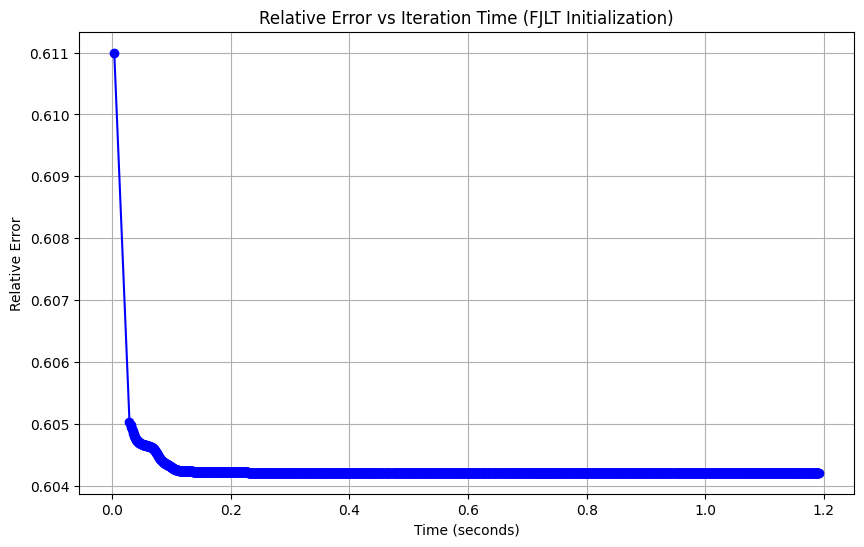

W shape: (100, 5)
H shape: (5, 50)
Final Relative Error: 0.6042124277116827


In [29]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import hadamard
from sklearn.decomposition import NMF

def next_power_of_2(x):
    """Returns the next power of 2 greater than or equal to x."""
    return 1 if x == 0 else 2**(x - 1).bit_length()

def fjlt_transform(A, d):
    """
    Applies Fast Johnson-Lindenstrauss Transform (FJLT) to reduce dimensions.
    Uses a Hadamard-based random projection for efficiency.
    
    Parameters:
        A (numpy.ndarray): Input matrix of shape (m, n)
        d (int): Target lower dimension
    
    Returns:
        numpy.ndarray: Transformed matrix
    """
    m, n = A.shape
    d = min(n, d)  # Ensure d does not exceed n
    hadamard_size = next_power_of_2(n)  # Ensure H operates on n
    H = hadamard(hadamard_size)[:n, :n]  # Square Hadamard matrix
    R = np.random.choice([-1, 1], size=(n, d)) / np.sqrt(d)  # Random sign matrix
    A_fjlt = (A @ H) @ R  # Apply H to A properly, no slicing required
    
    if A_fjlt is None or A_fjlt.size == 0:
        raise ValueError("FJLT transformation returned an invalid matrix")
    
    return A_fjlt

def nmf_fjlt_init(A, rank):
    """
    Initializes NMF using FJLT-based randomized SVD.
    
    Parameters:
        A (numpy.ndarray): Input non-negative matrix (m, n)
        rank (int): Target rank for NMF
    
    Returns:
        W_init, H_init: Initialized factor matrices
    """
    # Step 1: Apply FJLT to A
    A_fjlt = fjlt_transform(A, rank)
    print("A_fjlt shape:", A_fjlt.shape)
    
    # Step 2: Apply SVD on transformed matrix
    U, S, Vt = np.linalg.svd(A_fjlt, full_matrices=False)
    min_dim = min(U.shape[1], Vt.shape[0], rank)  # Ensure valid rank selection
    
    # Step 3: Construct non-negative initial factors
    W_init = np.abs(U[:, :min_dim] @ np.diag(np.sqrt(S[:min_dim])))  # W_init shape: (m, rank)
    H_init = np.abs(np.diag(np.sqrt(S[:min_dim])) @ Vt[:min_dim, :])  # H_init shape: (rank, d)
    
    # Step 4: Project H_init back to the original space
    hadamard_size = next_power_of_2(A.shape[1])  # Ensure H operates on n
    H = hadamard(hadamard_size)[:A.shape[1], :A.shape[1]]  # Square Hadamard matrix
    R = np.random.choice([-1, 1], size=(A.shape[1], rank)) / np.sqrt(rank)  # Random sign matrix
    H_init = H_init @ R.T  # Project H_init back to (rank, n)
    H_init = np.maximum(H_init, 0)
    print("W_init shape:", W_init.shape)
    print("H_init shape:", H_init.shape)
    
    return W_init, H_init

def nmf_with_fjlt(A, rank, max_iter=200):
    """
    Runs NMF with FJLT-based initialization.
    
    Parameters:
        A (numpy.ndarray): Input non-negative matrix (m, n)
        rank (int): Target rank for NMF
        max_iter (int): Maximum number of NMF iterations
    
    Returns:
        W, H: Factorized matrices from NMF
    """
    W_init, H_init = nmf_fjlt_init(A, rank)
    
    # Ensure W_init is of shape (m, rank) and H_init is of shape (rank, n)
    if W_init.shape[1] != rank or H_init.shape[0] != rank:
        raise ValueError(f"Invalid shapes for W_init or H_init: W_init shape: {W_init.shape}, H_init shape: {H_init.shape}")
    
    print(f"A shape: {A.shape}, W_init shape: {W_init.shape}, H_init shape: {H_init.shape}")
    
    # Initialize NMF with custom W_init and H_init
    nmf = NMF(n_components=rank, init='custom', max_iter=max_iter, solver='mu')
    
    # Lists to store relative error and iteration time
    relative_errors = []
    iteration_times = []
    start_time = time.time()
    
    # Manually track relative error and time
    for i in range(max_iter):
        nmf.fit(A, W=W_init, H=H_init)
        W = nmf.transform(A)
        H = nmf.components_
        
        # Compute relative error
        A_reconstructed = W @ H
        reconstruction_error = np.linalg.norm(A - A_reconstructed, ord='fro')
        norm_A = np.linalg.norm(A, ord='fro')
        relative_error = reconstruction_error / norm_A
        
        # Record relative error and time
        relative_errors.append(relative_error)
        iteration_times.append(time.time() - start_time)
        print(f"Iteration {i + 1}: Relative Error = {relative_error:.4f}, Time = {iteration_times[-1]:.2f} seconds")
    
    # Plot relative error vs iteration time
    plt.figure(figsize=(10, 6))
    plt.plot(iteration_times, relative_errors, marker='o', linestyle='-', color='b')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Relative Error")
    plt.title("Relative Error vs Iteration Time (FJLT Initialization)")
    plt.grid(True)
    plt.show()
    
    return W, H

# Example Usage:
m, n, rank = 100, 50, 5
A = np.abs(np.random.randn(m, n))  # Simulated non-negative matrix
W, H = nmf_with_fjlt(A, rank, max_iter=2000)
print("W shape:", W.shape)
print("H shape:", H.shape)

A_reconstructed = W @ H

# Calculate reconstruction error
reconstruction_error = np.linalg.norm(A - A_reconstructed, ord='fro')

# Calculate Frobenius norm of A
norm_A = np.linalg.norm(A, ord='fro')

# Calculate relative error
relative_error = reconstruction_error / norm_A

print("Final Relative Error:", relative_error)

In [32]:
import numpy as np

def randomized_evd(A, k, p=10, q=2):
    """
    Approximates the top-k eigenvalues and eigenvectors of a matrix A using randomized EVD.

    Parameters:
        A (numpy.ndarray): Input matrix of shape (m, n).
        k (int): Target rank (number of eigenvalues/eigenvectors to compute).
        p (int): Oversampling parameter (default: 10).
        q (int): Number of power iterations (default: 2).

    Returns:
        eigenvalues (numpy.ndarray): Approximated eigenvalues of shape (k,).
        eigenvectors (numpy.ndarray): Approximated eigenvectors of shape (m, k).
    """
    m, n = A.shape
    
    # Step 1: Random projection
    Omega = np.random.randn(n, k + p)  # Random Gaussian matrix
    Y = A @ Omega  # Project A into a lower-dimensional space
    
    # Step 2: Power iterations (optional, improves accuracy)
    for _ in range(q):
        Y = A @ (A.T @ Y)
    
    # Step 3: QR decomposition to get an orthonormal basis
    Q, _ = np.linalg.qr(Y, mode='reduced')
    
    # Step 4: Project A into the lower-dimensional space
    B = Q.T @ A @ Q
    
    # Step 5: Eigenvalue decomposition of B
    eigenvalues, eigenvectors_B = np.linalg.eigh(B)
    
    # Step 6: Recover eigenvectors of A
    eigenvectors = Q @ eigenvectors_B
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx][:k]
    eigenvectors = eigenvectors[:, idx][:, :k]
    
    return eigenvalues, eigenvectors

# Example Usage
m, n, k = 1000, 500, 10
A = np.random.randn(m, n)  # Random matrix
eigenvalues, eigenvectors = randomized_evd(A, k)

print("Eigenvalues:", eigenvalues)
print("Eigenvectors shape:", eigenvectors.shape)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 500)

In [39]:
import numpy as np
from sklearn.decomposition import NMF

def pad_to_square(A):
    """
    Pads the input matrix A with zeros to make it square.
    
    Parameters:
        A (numpy.ndarray): Input matrix of shape (m, n)
    
    Returns:
        numpy.ndarray: Padded square matrix
    """
    m, n = A.shape
    max_dim = max(m, n)
    padded_A = np.zeros((max_dim, max_dim))
    padded_A[:m, :n] = A  # Place A in the top-left corner
    return padded_A

def initialize_nmf_with_evd(A, rank):
    """
    Initializes NMF using Eigenvalue Decomposition (EVD).
    
    Parameters:
        A (numpy.ndarray): Input non-negative matrix of shape (m, n)
        rank (int): Target rank for NMF
    
    Returns:
        W_init (numpy.ndarray): Initialized basis matrix of shape (m, rank)
        H_init (numpy.ndarray): Initialized coefficient matrix of shape (rank, n)
    """
    m, n = A.shape
    
    # Step 1: Pad A to a square matrix if necessary
    if m != n:
        A_square = pad_to_square(A)
    else:
        A_square = A
    
    # Step 2: Perform Eigenvalue Decomposition (EVD)
    eigenvalues, eigenvectors = np.linalg.eigh(A_square)
    
    # Step 3: Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]  # Sort in descending order
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Step 4: Extract top-k eigenvalues and eigenvectors
    eigenvalues_k = eigenvalues[:rank]
    eigenvectors_k = eigenvectors[:, :rank]
    
    # Step 5: Project back to original dimensions (if padding was applied)
    if m != n:
        eigenvectors_k = eigenvectors_k[:m, :]  # Truncate to original rows
    
    # Step 6: Construct non-negative initial factors
    W_init = np.abs(eigenvectors_k)  # Basis matrix (m, rank)
    H_init = np.abs(np.diag(eigenvalues_k) @ eigenvectors_k.T)  # Coefficient matrix (rank, n)
    
    # Ensure H_init has the correct shape (rank, n)
    if H_init.shape[1] != n:
        H_init = H_init[:, :n]
    
    return W_init, H_init

def nmf_with_evd_init(A, rank, max_iter=200):
    """
    Runs NMF with EVD-based initialization.
    
    Parameters:
        A (numpy.ndarray): Input non-negative matrix of shape (m, n)
        rank (int): Target rank for NMF
        max_iter (int): Maximum number of NMF iterations
    
    Returns:
        W (numpy.ndarray): Basis matrix of shape (m, rank)
        H (numpy.ndarray): Coefficient matrix of shape (rank, n)
    """
    # Step 1: Initialize NMF factors using EVD
    W_init, H_init = initialize_nmf_with_evd(A, rank)
    
    # Step 2: Run NMF with custom initialization
    nmf = NMF(n_components=rank, init='custom', max_iter=max_iter, solver='mu')
    nmf.fit(A, W=W_init, H=H_init)  # Use fit instead of fit_transform
    W = nmf.transform(A)  # Use transform to get W from the fitted model
    H = nmf.components_  # The H matrix is stored as components_
    
    return W, H

# Example Usage
m, n, rank = 100, 50, 5
A = np.abs(np.random.randn(m, n))  # Simulated non-negative matrix
W, H = nmf_with_evd_init(A, rank, max_iter=2000)

print("W shape:", W.shape)
print("H shape:", H.shape)

# Calculate reconstruction error
A_reconstructed = W @ H
reconstruction_error = np.linalg.norm(A - A_reconstructed, ord='fro')
norm_A = np.linalg.norm(A, ord='fro')
relative_error = reconstruction_error / norm_A

print("Relative Reconstruction Error:", relative_error)

W shape: (100, 5)
H shape: (5, 50)
Relative Reconstruction Error: 0.5305036079758669


In [40]:
reconstruction_error

np.float64(37.81580822577346)

In [41]:
nmf = NMF(n_components=rank,max_iter=2000,init = 'random')
nmf.fit(A)
W = nmf.transform(A)  # Use transform to get W from the fitted model
H = nmf.components_  # The H matrix is stored as components_
reconstruction_error = np.linalg.norm(A - W @ H, ord='fro')
print("Reconstruction Error:", reconstruction_error)

Reconstruction Error: 37.73398013496071


In [42]:
import numpy as np
from sklearn.decomposition import NMF

def pad_to_square(image):
    """
    Pads the input image with zeros to make it square.
    
    Parameters:
        image (numpy.ndarray): Input image matrix of shape (height, width)
    
    Returns:
        numpy.ndarray: Padded square image
    """
    height, width = image.shape
    max_dim = max(height, width)
    padded_image = np.zeros((max_dim, max_dim))
    padded_image[:height, :width] = image  # Place the image in the top-left corner
    return padded_image

def initialize_nmf_with_evd(image, rank):
    """
    Initializes NMF using Eigenvalue Decomposition (EVD) of the padded square image.
    
    Parameters:
        image (numpy.ndarray): Input image matrix of shape (height, width)
        rank (int): Target rank for NMF
    
    Returns:
        W_init (numpy.ndarray): Initialized basis matrix of shape (height, rank)
        H_init (numpy.ndarray): Initialized coefficient matrix of shape (rank, width)
    """
    height, width = image.shape
    
    # Step 1: Pad the image to a square matrix
    padded_image = pad_to_square(image)
    
    # Step 2: Perform Eigenvalue Decomposition (EVD)
    eigenvalues, eigenvectors = np.linalg.eigh(padded_image)
    
    # Step 3: Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]  # Sort in descending order
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Step 4: Extract top-k eigenvalues and eigenvectors
    eigenvalues_k = eigenvalues[:rank]
    eigenvectors_k = eigenvectors[:, :rank]
    
    # Step 5: Project back to original dimensions (if padding was applied)
    if height != width:
        eigenvectors_k = eigenvectors_k[:height, :]  # Truncate to original rows
    
    # Step 6: Construct non-negative initial factors
    W_init = np.abs(eigenvectors_k)  # Basis matrix (height, rank)
    H_init = np.abs(np.diag(eigenvalues_k) @ eigenvectors_k.T)  # Coefficient matrix (rank, width)
    
    # Ensure H_init has the correct shape (rank, width)
    if H_init.shape[1] != width:
        H_init = H_init[:, :width]
    
    return W_init, H_init

def nmf_with_evd_init(image, rank, max_iter=200):
    """
    Runs NMF with EVD-based initialization.
    
    Parameters:
        image (numpy.ndarray): Input image matrix of shape (height, width)
        rank (int): Target rank for NMF
        max_iter (int): Maximum number of NMF iterations
    
    Returns:
        W (numpy.ndarray): Basis matrix of shape (height, rank)
        H (numpy.ndarray): Coefficient matrix of shape (rank, width)
    """
    # Step 1: Initialize NMF factors using EVD
    W_init, H_init = initialize_nmf_with_evd(image, rank)
    
    # Step 2: Run NMF with custom initialization
    nmf = NMF(n_components=rank, init='custom', max_iter=max_iter, solver='mu')
    nmf.fit(image, W=W_init, H=H_init)  # Use fit instead of fit_transform
    W = nmf.transform(image)  # Use transform to get W from the fitted model
    H = nmf.components_  # The H matrix is stored as components_
    
    return W, H

# Example Usage
height, width, rank = 100, 200, 10
image = np.abs(np.random.randn(height, width))  # Simulated grayscale image
W, H = nmf_with_evd_init(image, rank, max_iter=2000)

print("W shape:", W.shape)
print("H shape:", H.shape)

# Calculate reconstruction error
image_reconstructed = W @ H
reconstruction_error = np.linalg.norm(image - image_reconstructed, ord='fro')
norm_image = np.linalg.norm(image, ord='fro')
relative_error = reconstruction_error / norm_image

print("Relative Reconstruction Error:", relative_error)

ValueError: Array with wrong second dimension passed to NMF (input H). Expected 200, but got 100.